In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import tensorflow as tf
from tf_keras_vis.utils import num_of_gpus

_, gpus = num_of_gpus()
print('Tensorflow recognized {} GPUs'.format(gpus))

Tensorflow recognized 0 GPUs


In [2]:
from tensorflow.keras.applications.vgg16 import VGG16

model = VGG16(weights='imagenet', include_top=True)
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

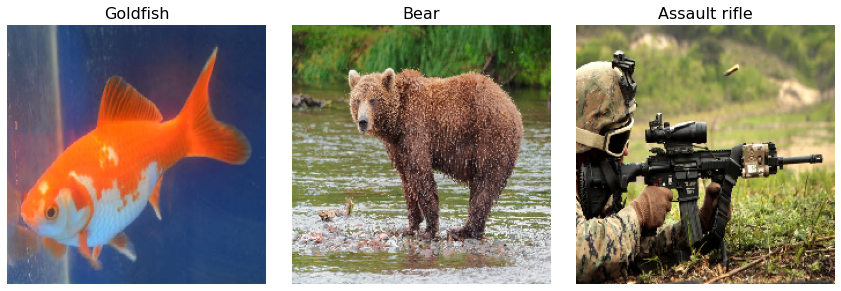

In [15]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.vgg16 import preprocess_input

# Image titles
image_titles = ['Goldfish', 'Bear', 'Assault rifle']

# Load images and Convert them to a Numpy array
img1 = load_img('images/goldfish.jpg', target_size=(224, 224))
img2 = load_img('images/bear.jpg', target_size=(224, 224))
img3 = load_img('images/soldiers.jpg', target_size=(224, 224))
images = np.asarray([np.array(img1), np.array(img2), np.array(img3)])

# Preparing input data for VGG16
X = preprocess_input(images)

# Rendering
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].axis('off')
plt.tight_layout()
plt.show()

In [7]:
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear

replace2linear = ReplaceToLinear()

# Instead of using the ReplaceToLinear instance above,
# you can also define the function from scratch as follows:
def model_modifier_function(cloned_model):
    cloned_model.layers[-1].activation = tf.keras.activations.linear

In [9]:
from tf_keras_vis.utils.scores import CategoricalScore

# 1 is the imagenet index corresponding to Goldfish, 294 to Bear and 413 to Assault Rifle.
score = CategoricalScore([1, 294, 413])

# Instead of using CategoricalScore object,
# you can also define the function from scratch as follows:
def score_function(output):
    # The `output` variable refers to the output of the model,
    # so, in this case, `output` shape is `(3, 1000)` i.e., (samples, classes).
    return (output[0][1], output[1][294], output[2][413])

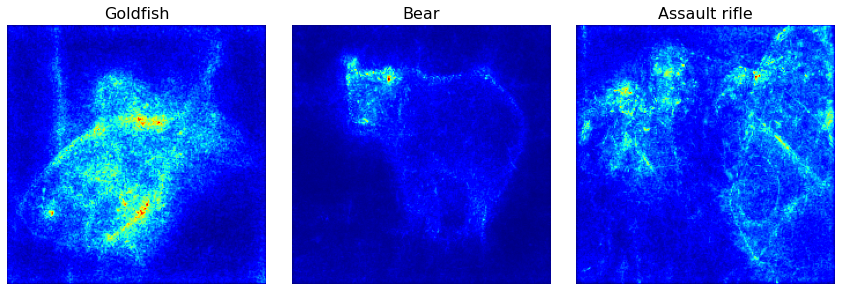

Wall time: 2min 10s


In [11]:
%%time
from tf_keras_vis.saliency import Saliency
# from tf_keras_vis.utils import normalize

# Create Saliency object.
saliency = Saliency(model,
                    model_modifier=replace2linear,
                    clone=True)

# Generate saliency map with smoothing that reduce noise by adding noise
saliency_map = saliency(score,
                        X,
                        smooth_samples=20, # The number of calculating gradients iterations.
                        smooth_noise=0.20) # noise spread level.

## Since v0.6.0, calling `normalize()` is NOT necessary.
# saliency_map = normalize(saliency_map)

# Render
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(saliency_map[i], cmap='jet')
    ax[i].axis('off')
plt.tight_layout()
plt.show()

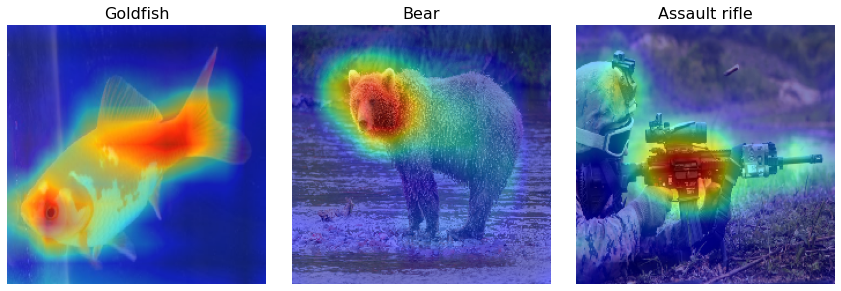

Wall time: 30 s


In [16]:
%%time

from matplotlib import cm
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus

# Create GradCAM++ object
gradcam = GradcamPlusPlus(model,
                          model_modifier=replace2linear,
                          clone=True)

# Generate heatmap with GradCAM++
cam = gradcam(score,
              X,
              penultimate_layer=-1)

## Since v0.6.0, calling `normalize()` is NOT necessary.
# cam = normalize(cam)

# Render
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5)
    ax[i].axis('off')
plt.tight_layout()
plt.savefig('images/gradcam_plus_plus.png')
plt.show()